# Vehicle Detection and Tracking

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

In [22]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:9999;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [11]:
import sys

def print_progress(iteration, total):
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

## Training a Classifier

### Reading the labeled data

In [4]:
vehicles = []
non_vehicles = []
vehicles_paths = glob.glob('labeled_data/vehicles/*/*.png')
non_vehicles_paths = glob.glob('labeled_data/non-vehicles/*/*.png')

def append_labeled_data(items, data_type):
    for item in items:
        data_type.append(mpimg.imread(item))
        print_progress(len(data_type), len(items))
        
    
append_labeled_data(vehicles_paths, vehicles)
append_labeled_data(non_vehicles_paths, non_vehicles)

# convert vehicles and non vehicles to numpy arrays
vehicles = np.asarray(vehicles)
non_vehicles = np.asarray(non_vehicles)

print('Data imported.')

print('Vehicle image count: {}'.format(vehicles.shape[0]))
print('Non Vehicle image count: {}'.format(non_vehicles.shape[0]))



 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
Data imported.
Vehicle image count: 8792
Non Vehicle image count: 8968


### Extracting Features 

In [6]:
from skimage.feature import hog

class ExtractFeatures(object):
    """Abstracts the multiple features that are extracted from each frame/image"""
    
    def __init__(self, img):    
        # convert img to YCrCb
        self.img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        self.height = self.img.shape[0]
        self.width  = self.img.shape[1]
        self.depth  = self.img.shape[2]
        self.pix_per_cell = 8
        self.features_hog = []
        self._init_hog()
        
    def _init_hog(self):
        for channel in range(self.depth):
            hog_feature = hog(self.img[:, :, channel], 
                              orientations=10, 
                              pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                              cells_per_block=(2, 2), 
                              transform_sqrt=True, 
                              visualise=False,
                              feature_vector=False)
            self.features_hog.append(hog_feature)
        # Convert to np array
        self.features_hog = np.asarray(self.features_hog)
        
    def _hog(self, x, y, s):
        _x = max((x // self.pix_per_cell) - 1, 0)
        _y = max((y // self.pix_per_cell) - 1, 0)
        _s = (s // self.pix_per_cell) - 1
        
        if (_x + _s) > self.features_hog.shape[2]:
            _x = self.features_hog.shape[2] - _s
            
        if (_y + _s) > self.features_hog.shape[1]:
            _y = self.features_hog.shape[1] - _s
        
        hog_region_features = np.ravel(self.features_hog[:, _y:_y + _s, _x:_x + _s, :, :, :])
        
        return hog_region_features
    
    def _bin_spatial(self, img, size=(32, 32)):
        spacial_vector = cv2.resize(img, size).ravel()
        
        return spacial_vector
        
    def _color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def features(self, x=0, y=0, s=64):
        """Returns a vector of the concatenated features"""
        features = []
        # Add spactial features
        spatial = self._bin_spatial(self.img[y:y + s, x:x + s, :])
        features.append(spatial)
        # Add HOG features 
        hog = self._hog(x, y, s)
        features.append(hog)
        # Add Histogram features
        hist = self._color_hist(self.img[y:y + s, x:x + s, :])
        features.append(hist)
        # Finally concatente them all and return
        return np.concatenate(features)
        

def extract_features(items, data_features):
    for item in items:
        features = ExtractFeatures(item).features()
        data_features.append(features)
        print_progress(len(data_features), len(items))

vehicle_features = []
non_vehicle_features = []

extract_features(vehicles, vehicle_features)
extract_features(non_vehicles, non_vehicle_features)

X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

 |----------------------------------------------------------------------------------------------------| 0%

/Users/mota/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


### Scalling Features

In [12]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))


### Train the classifier: Linear SVC

In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=43)
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
accuracy = round(linear_svc.score(X_test, y_test), 5)
print('Classifier Accuracy: {}'.format(accuracy))

Classifier Accuracy: 0.98902


## Detect Vehicles using the classifier

In [15]:
from collections import deque
from skimage.transform import resize
from scipy.ndimage.measurements import label


class VehicleDetector(object):
    """Abastracs the logic to detec vehicles in a stream of images"""

    def __init__(self, scaler, classifier, f_img):
        self.scaler = scaler
        self.classifier = classifier
        self.img_shape = f_img.shape
        self.history = deque(maxlen=20)

    def _detections_last_n_frames(self):
        detections, _ = self._merge_detections(
            np.concatenate(np.array(self.history)),
            self.img_shape,
            threshold=min(len(self.history), 15)
        )
        return detections

    def _sliding_window_pass(self, img):
        scales = np.array([0.3, 0.5, 0.65, 0.8])
        y_top  = np.array([0.6, 0.57, 0.56, 0.55])

        img_detections = np.empty([0, 4], dtype=np.int64)

        for scale, y in zip(scales, y_top):
            scale_detections = self._scale_and_apply_classifier(img, scale, y, 64)
            img_detections = np.append(img_detections, scale_detections, axis=0)

        detections, self.heatmap = self._merge_detections(img_detections, img.shape, threshold=1)

        self.history.append(detections)

    def _scale_and_apply_classifier(self, img, scale, y, k):
        (height, width, depth) = img.shape
        scaled = resize((img / 255.0).astype(np.float64),
                        (int(height * scale), int(width * scale), depth),
                        preserve_range=True).astype(np.float32)

        features_extractor = ExtractFeatures(scaled)
        (height, width, depth) = scaled.shape
        # Placeholder for detections
        detections = np.empty([0, 4], dtype=np.int)

        y = int(height * y)
        s = k // 3
        x_range = np.linspace(0, width - k, (width + s) // s)

        for x in x_range.astype(np.int):
            features = features_extractor.features(x, y, k)
            features = self.scaler.transform(np.array(features).reshape(1, -1))

            if self.classifier.predict(features)[0] == 1:
                detections = np.append(detections, [[x, y, x + k, y + k]], axis=0)

        return (detections / scale).astype(np.int)

    def _merge_detections(self, detections, img_shape, threshold):
        heatmap = np.zeros((img_shape[0], img_shape[1])).astype(np.float)
        heatmap = self._add_heatmap(heatmap, detections)

        # Apply threshold to remove false positives
        heatmap[heatmap < threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)

        labels = label(heatmap)
        vehicles = np.empty([0, 4], dtype=np.int64)

        # for each detected vehicle:
        for vehicle in range(1, labels[1] + 1):
            nonzero = (labels[0] == vehicle).nonzero()
            nonzero_min_max = [[np.min(nonzero[1]), np.min(nonzero[0]),
                                np.max(nonzero[1]), np.max(nonzero[0])]]
            vehicles = np.append(vehicles, nonzero_min_max, axis=0)

        return (vehicles, heatmap)

    def _add_heatmap(self, heatmap, detections):
        for d in detections:
            heatmap[d[1]:d[3], d[0]:d[2]] += 1

        return heatmap

    def run(self, img, draw=True):
        self._sliding_window_pass(img)

        if draw:
            for d in self._detections_last_n_frames():
                cv2.rectangle(img, (d[0], d[1]), (d[2], d[3]), (0, 0, 255), 2)

        return img



## Use the classifier on a set of test images

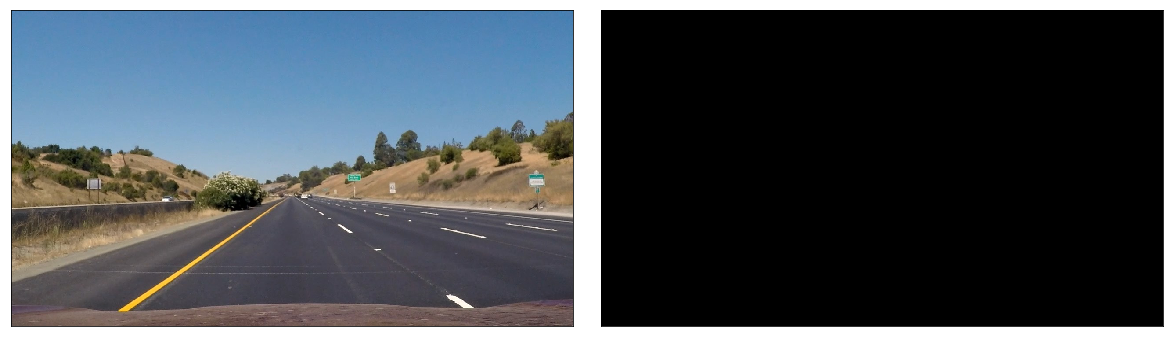

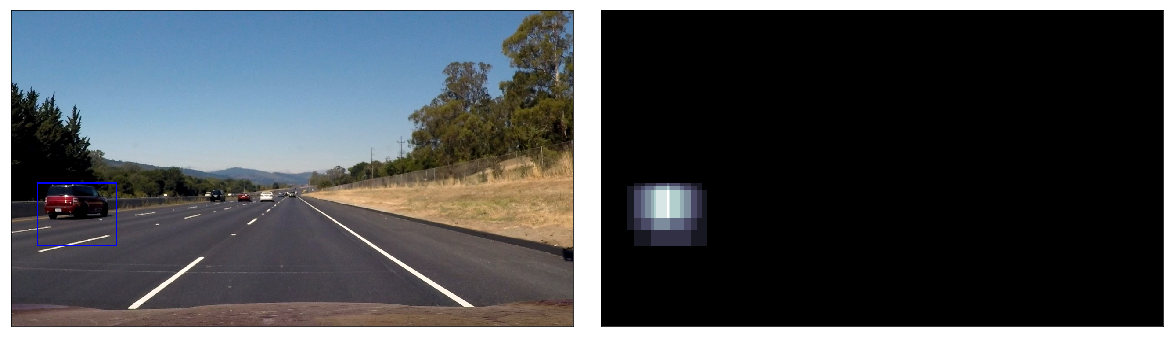

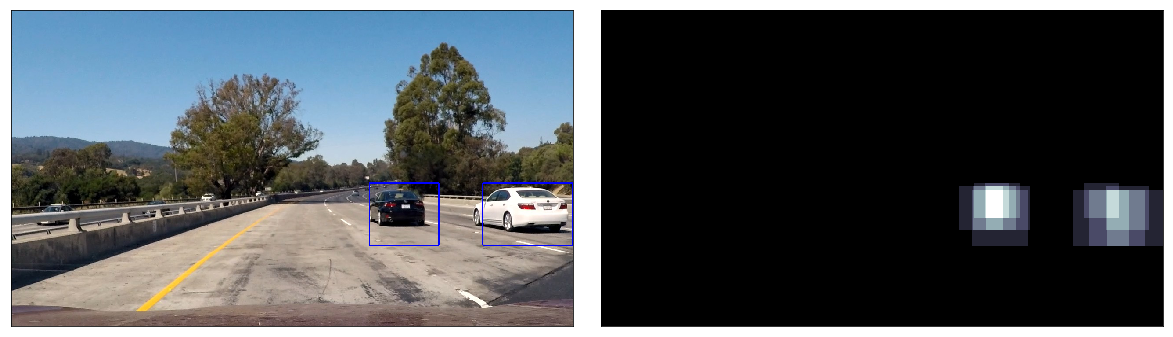

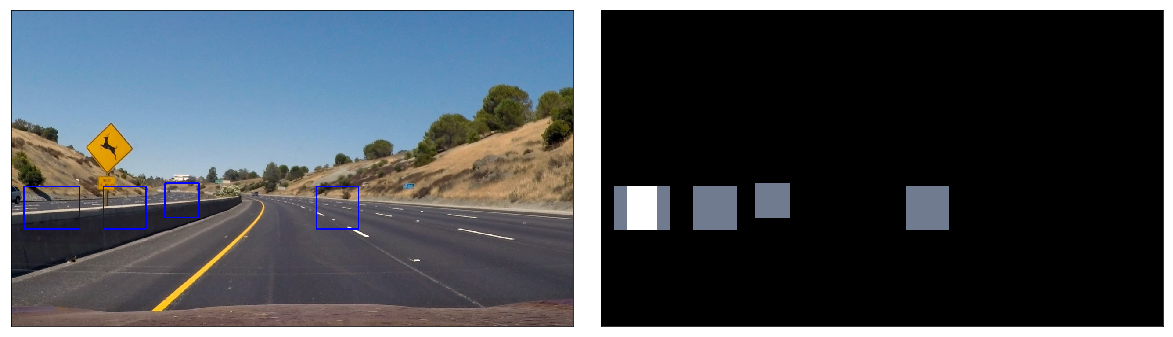

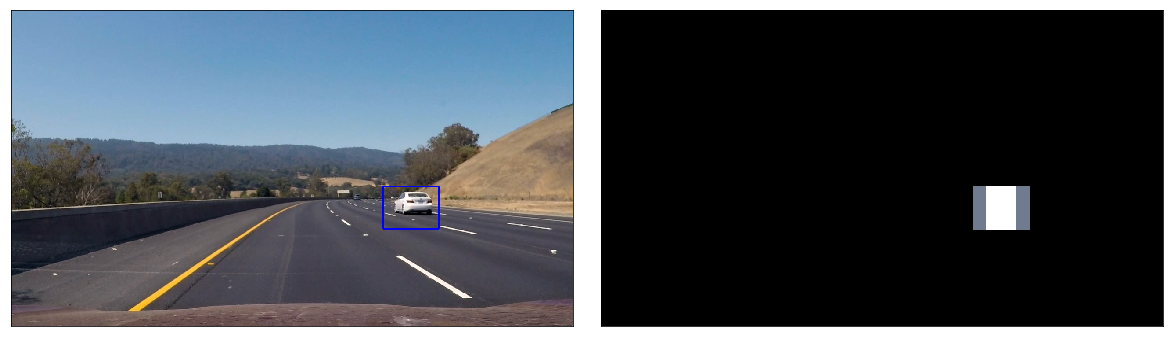

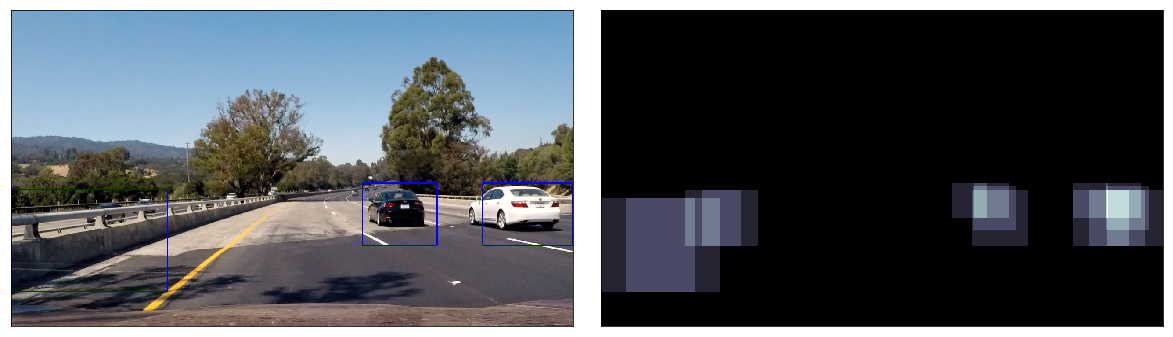

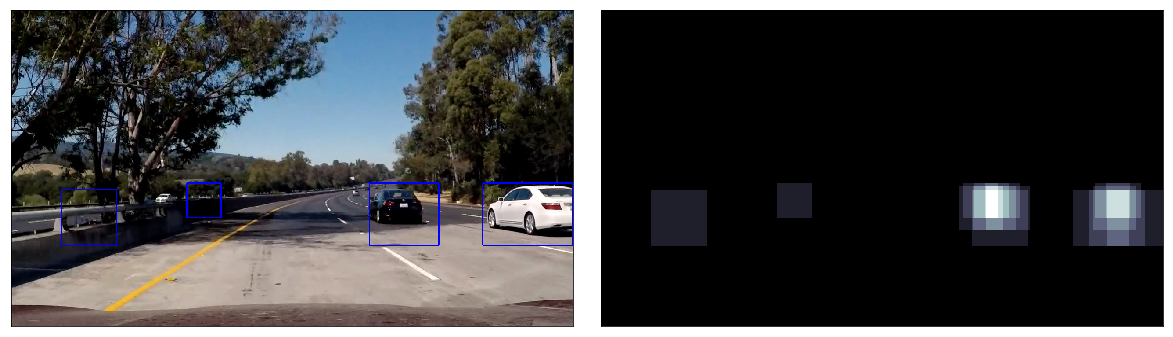

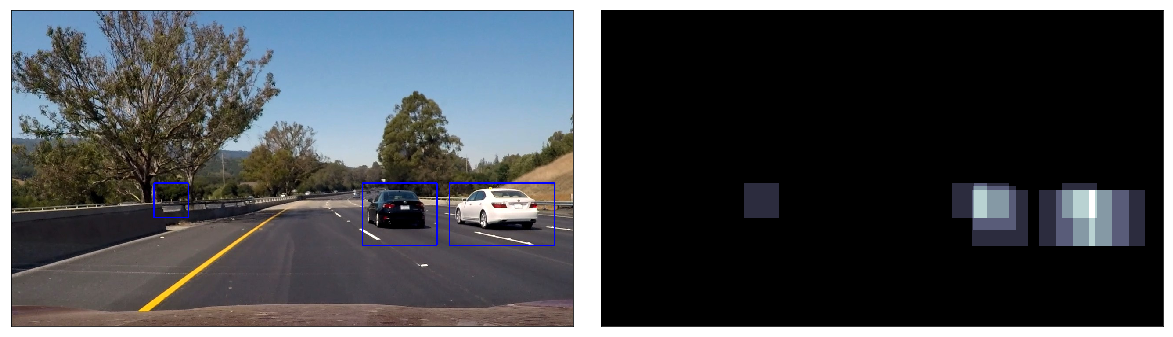

In [23]:
for image_path in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_path)
    detection = VehicleDetector(X_scaler, linear_svc, image)
    detection.run(image)
    
    f = plt.figure(figsize=(16, 8))
    f.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    a = f.add_subplot(1, 2, 1, xticks=[], yticks=[])
    a.imshow(image)
    
    a = f.add_subplot(1, 2, 2, xticks=[], yticks=[])
    a.imshow(detection.heatmap, cmap='bone')
    
    plt.show


## Apply the vehicle detection to the video

In [17]:
from moviepy.editor import VideoFileClip

def build_augmented_video(video_path_prefix):
    output_video_name = 'videos/{}_augmented.mp4'.format(video_path_prefix)
    input_video = VideoFileClip("videos/{}.mp4".format(video_path_prefix))

    detection = VehicleDetector(X_scaler, linear_svc, input_video.get_frame(0))

    output_video = input_video.fl_image(detection.run)

    %time output_video.write_videofile(output_video_name, audio=False)

Applying it to the simplest video

In [39]:
build_augmented_video('project_video')

[MoviePy] >>>> Building video videos/project_video_augmented.mp4
[MoviePy] Writing video videos/project_video_augmented.mp4


100%|█████████▉| 1260/1261 [55:50<00:02,  2.66s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_augmented.mp4 

CPU times: user 51min, sys: 5min 15s, total: 56min 16s
Wall time: 55min 51s


Applying it to a challenging video

In [ ]:
build_augmented_video('challenge_video')

[MoviePy] >>>> Building video videos/challenge_video_augmented.mp4
[MoviePy] Writing video videos/challenge_video_augmented.mp4


100%|█████████▉| 483/485 [21:27<00:05,  2.56s/it]

Applying it to a harder challenging video

In [ ]:
build_augmented_video('harder_challenge_video')

Create a GIF for the writeup

In [20]:
def gif_from_video(video_path_prefix, s=(0,0), f=(0,15)):
    video_file = 'videos/{}_augmented.mp4'.format(video_path_prefix)
    
    clip = (VideoFileClip(video_file).subclip(s,f).resize(0.5))
    %time clip.write_gif('videos/{}_augmented.gif'.format(video_path_prefix), fps=10)


In [ ]:
gif_from_video('project_video',s=(0, 26), f=(0,46))

Detect vehicles on the augmented video from [Advanced Lane Finding](https://github.com/ricardosllm/CarND-Advanced-Lane-Finding)

In [18]:
build_augmented_video('advanced_lane_finding_video')

[MoviePy] >>>> Building video videos/advanced_lane_finding_video_augmented.mp4
[MoviePy] Writing video videos/advanced_lane_finding_video_augmented.mp4


100%|█████████▉| 1260/1261 [59:19<00:03,  3.08s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/advanced_lane_finding_video_augmented.mp4 

CPU times: user 40min 30s, sys: 8min 56s, total: 49min 26s
Wall time: 59min 21s


In [21]:
gif_from_video('advanced_lane_finding_video',s=(0, 26), f=(0,46))


[MoviePy] Building file videos/advanced_lane_finding_video_augmented.gif with imageio


100%|█████████▉| 200/201 [00:30<00:00,  6.83it/s]

CPU times: user 20.9 s, sys: 2.29 s, total: 23.2 s
Wall time: 30.3 s
